# Data Analysis & Scoring

## Exploratory Mapping

Mapping these data are easy. Here, the `R` commands below take about 2 minutes to run. To map these data, we'll need to:
1. import data
3. join data
4. map and refine

### Import Data

I use `sf` for most spatial processes, `tidyverse` for general data wrangling, and `tmap` for interactive mapping.

In [1]:
library(tidyverse)
library(sf)
library(tmap)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Linking to GEOS 3.10.2, GDAL 3.4.3, PROJ 8.2.0; sf_use_s2() is TRUE



Data come from the City of Boston's [open data portal](https://data.boston.gov/dataset?q=property+assessment).

In [2]:
parcel_file <- tempfile()
download.file("https://bostonopendata-boston.opendata.arcgis.com/datasets/boston::parcels-2021.geojson", parcel_file)

Bringing these files in as `sf` objects will let us manipulate them.
It's important to keep in mind that parcel data for 2022 has not yet been published; I'm using property assessment 2021 data as a result.

In [3]:
parcels <- read_sf(parcel_file, quiet = FALSE)
prop_assess <- read_csv("https://data.boston.gov/dataset/e02c44d2-3c64-459c-8fe2-e1ce5f38a035/resource/c4b7331e-e213-45a5-adda-052e4dd31d41/download/data2021-full.csv")

Reading layer `Parcels_2021' from data source `/tmp/Rtmp2yKUJj/file25c55f1b1e5f' using driver `GeoJSON'
Simple feature collection with 99105 features and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -71.19091 ymin: 42.22792 xmax: -70.86865 ymax: 42.39699
Geodetic CRS:  WGS 84


Rows: 177091 Columns: 63
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (45): PID, CM_ID, GIS_ID, ST_NUM, ST_NAME, UNIT_NUM, CITY, ZIPCODE, LUC,...
dbl (18): BLDG_SEQ, NUM_BLDGS, RES_FLOOR, CD_FLOOR, RES_UNITS, COM_UNITS, LA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Clean Data

These data are about as clean as can be, but we can do my laptop a service my removing many records.

In [4]:
prop_assess <- filter(prop_assess, CITY == 'MATTAPAN')

## Join Data

In [5]:
property <- parcels %>%
    select(MAP_PAR_ID, geometry) %>%
    inner_join(prop_assess, by = c('MAP_PAR_ID' = 'GIS_ID'))

## Render Map

We'll render a view that generates 4 maps, so that parcels can be compared across multiple types of data.

tmap mode set to plotting

Variable(s) "Year Built (From 1990)" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.



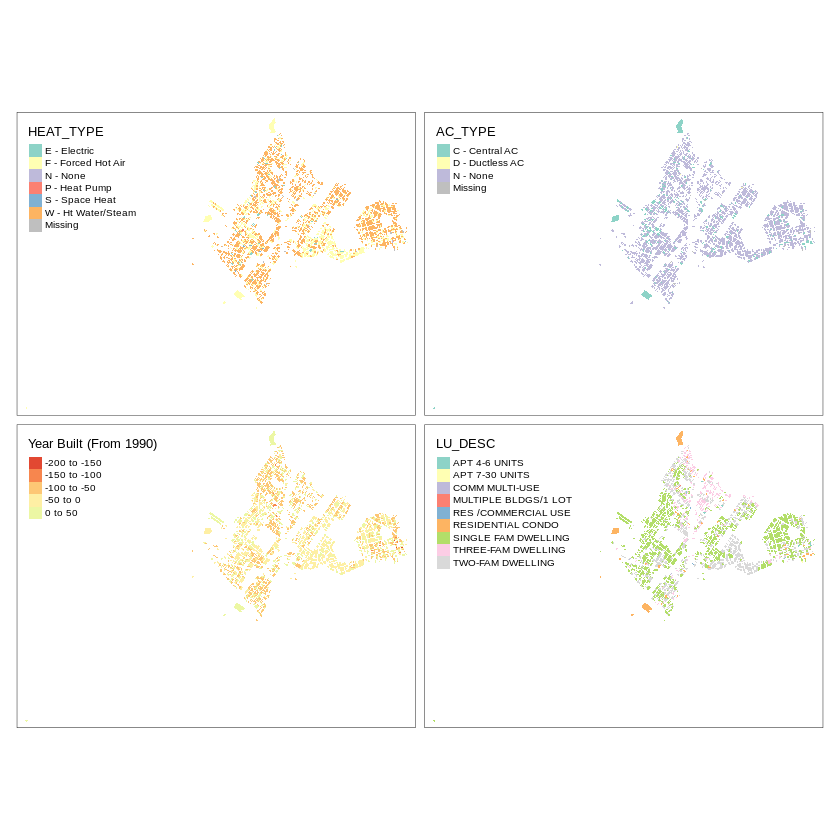

In [8]:
tmap_mode('plot')
property %>%
  filter(OWN_OCC == 'Y') %>%
  unite('address', c('ST_NUM', 'ST_NAME'), sep = ' ') %>%
  mutate('Year Built (From 1990)' = coalesce(YR_REMODEL, YR_BUILT)-1990) %>%
  tm_shape() +
  tm_fill(c('HEAT_TYPE', 'AC_TYPE', 'Year Built (From 1990)', 'LU_DESC'), id = 'address', popup.vars = c('YR_BUILT', 'HEAT_TYPE', 'AC_TYPE')) +
  tm_facets(nrow = 2, ncol = 2, sync = TRUE) +
  tm_basemap(server = 'OpenStreetMap', alpha = .5) +
  tm_view(bbox = 'Mattapan, Boston')